2019-11-03

This workbook has been used to explore and analyze trucking data with the goal of creating a predictive model of Revenue per a shipment. 

Outline (Use the links to jump to those sections):
- [Data Importing](#import)
- [Data Exploration](#explore)
- [Data Modeling](#model)
- [Final Model](#final)

In [1]:
%matplotlib inline

#import likely needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importing the data 
<a id='import'></a>

In [2]:
df = pd.read_csv('Data Science Case Study - Dataset.csv',
                 header=None,
                 names=['CustomerName','ParentName','LoadId','SalesMedium','CreatedDate',
                        'BookedDate','PickupDate','DeliveryDate','Revenue','Cost','Mode',
                        'Distance','OriginCode','OriginState','DestinationCode',
                        'DestinationState'],
                 parse_dates=['CreatedDate', 'BookedDate', 'PickupDate', 'DeliveryDate'])
df.head()

C:\Users\Aaren\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CustomerName,ParentName,LoadId,SalesMedium,CreatedDate,BookedDate,PickupDate,DeliveryDate,Revenue,Cost,Mode,Distance,OriginCode,OriginState,DestinationCode,DestinationState
0,Plussunin,NaN,B5DE5D66-A44B-4E7C-8937-43569786D5B2,Salesfloor,2017-07-18,2017-07-18,2017-07-18,2017-07-19,94.0,73.0,LTL,397.0,4087494,MN,3705744,IL
1,Plussunin,NaN,6ED8AFB6-3156-4349-B256-4428B63D770A,Salesfloor,2017-08-29,2017-08-29,2017-08-29,2017-08-30,119.0,92.0,LTL,296.0,4516151,PA,3854611,NY
2,Plussunin,NaN,3FF02E9A-47A3-4006-991E-7279A88BE595,Salesfloor,2018-08-09,2018-08-09,2018-08-09,2018-08-10,110.0,85.0,LTL,370.0,4282015,PA,3854611,NY
3,Plussunin,NaN,9ED5BD71-4D71-4AE8-9588-6FE3B74146FD,Salesfloor,2018-01-27,2018-01-27,2018-01-30,2018-02-01,125.0,97.0,LTL,641.0,6186793,WI,3854611,NY
4,Plussunin,NaN,9C436C5A-B892-4EAC-B8A9-9DFAAB075968,Contract,2018-03-22,2018-03-22,2018-03-22,2018-03-23,129.0,100.0,LTL,370.0,4282015,PA,3854611,NY


In [3]:
#Convert Origin Code and Destination Code to string
df['OriginCode'] = df['OriginCode'].astype(str)
df['DestinationCode'] = df['DestinationCode'].astype(str)

### Data Exploration
<a id='explore'></a>

In [5]:
#What's the shape of the dataset
df.shape

(709115, 16)

In [6]:
#Check for missing values
pd.DataFrame([(c, sum(df[c].isna())) for c in df.columns], 
             columns=['column','missing values'])

,column,missing values
0,CustomerName,0
1,ParentName,702498
2,LoadId,0
3,SalesMedium,10922
4,CreatedDate,0
5,BookedDate,2
6,PickupDate,13704
7,DeliveryDate,0
8,Revenue,14073
9,Cost,11593


In this project Revenue is the target value to predicted. Rows with missing Revenue will be **removed**. Additionally, there are a number missing values in many of the other columns. 

In [7]:
#filter out missing revenue
f_missing_revenue = df['Revenue'].notnull()
df = df.loc[f_missing_revenue]

count    695042.000000
mean        355.139459
std         653.143006
min           7.000000
25%         115.000000
50%         157.000000
75%         297.000000
max      247395.000000
Name: Revenue, dtype: float64

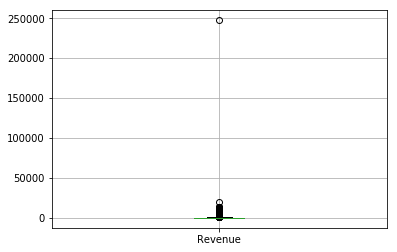

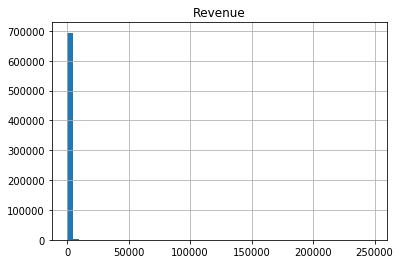

In [8]:
#Explore Revenue
df.boxplot('Revenue')
df.hist('Revenue', bins=50)
df['Revenue'].describe()

There appear to be a few outliers in Revenue. The vast majority of the values are below 2500. The 75% quantile is less than 300. While I do not know how this data was generated, I will assume that these outliers are in error and remove them from the dataset.

In [9]:
#Will remove outliers based on z-score method
from scipy import stats
mean = df['Revenue'].mean()
std = df['Revenue'].std()
df['Rev-z'] = np.abs((df['Revenue'] - mean) / std)
threshold = 3
f_outliers = df['Rev-z'] <= threshold
df = df.loc[f_outliers]

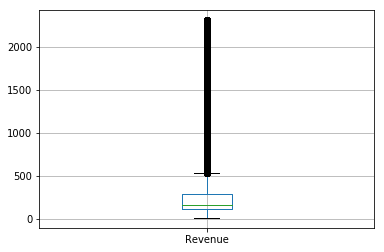

In [10]:
df.boxplot('Revenue')

In [11]:
print('Removed any row with Revenue >: {}'.format( (threshold*std)+mean ))

Removed any row with Revenue >: 2314.5684767210328


In [12]:
# Looking at number of different customers
print("Num of unique list of customers: {}".format( len(df['CustomerName'].unique()) ) )
print("Num of unique list of parent customers: {}".format( len(df['ParentName'].unique()) ) )

Num of unique list of customers: 66
Num of unique list of parent customers: 3


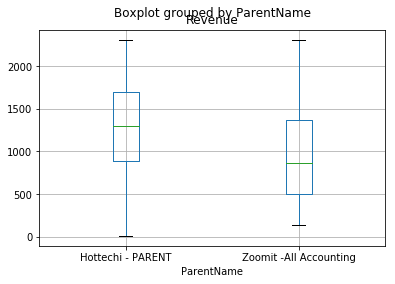

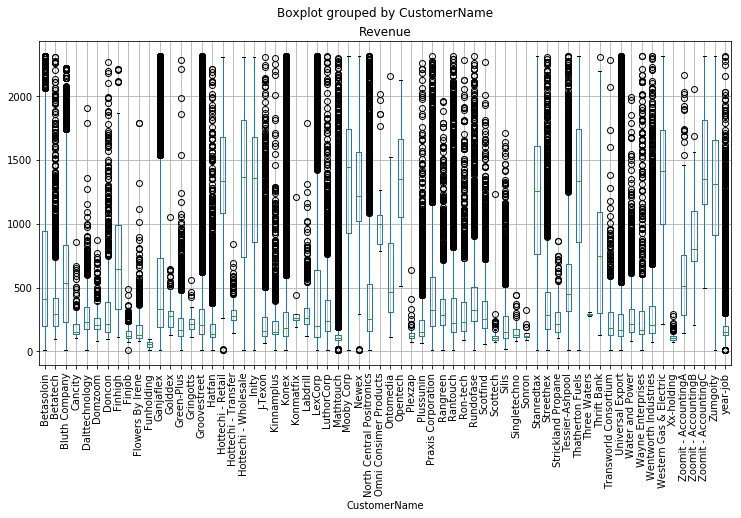

In [13]:
df.boxplot('Revenue', by='ParentName')
df.boxplot('Revenue', by='CustomerName', figsize=(12,6), rot=90)

There appear to be some significant differences in revenue between customers. Could be a useful feature. However, there are very few accounts with ParentNames.

Revenue                                                    \
                count        mean         std  min    25%    50%    75%   
SalesMedium                                                               
Contract     217545.0  285.204064  349.995559  7.0  113.0  152.0  274.0   
Salesfloor   452213.0  292.255689  356.256148  7.0  114.0  156.0  284.0   

                     
                max  
SalesMedium          
Contract     2314.0  
Salesfloor   2314.0

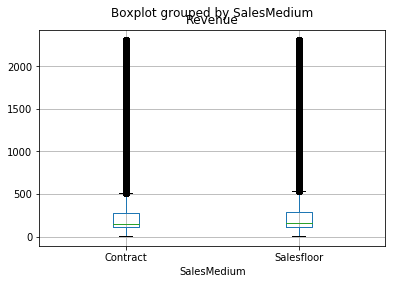

In [14]:
#Explore SalesMedium
df.boxplot('Revenue', by='SalesMedium')
df.loc[:,['Revenue','SalesMedium']].groupby('SalesMedium').describe()

There does not appear to be much difference revenue by SalesMedium.

In [15]:
#Explore CreateDate
print("The CreatedDate min:{} and max:{}".format(df['CreatedDate'].min(),  df['CreatedDate'].max()) ) 

The CreatedDate min:2015-09-24 00:00:00 and max:2020-10-07 00:00:00


Clearly there is some incorrect data because we have dates in the dataset that have not yet occurred. 

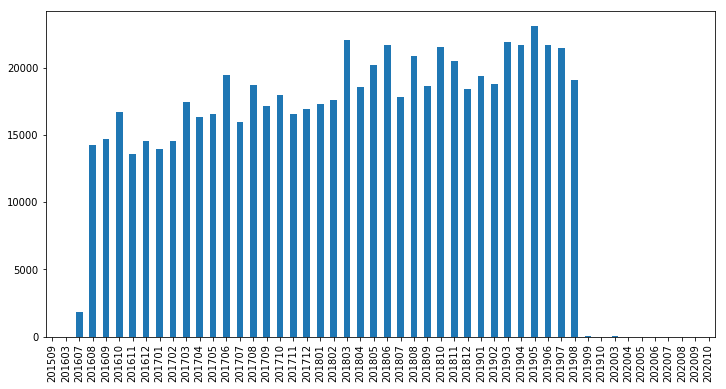

In [16]:
#convert to Month and Year an count the number of shipments
df['CreateYM'] = df['CreatedDate'].map(lambda x: x.strftime('%Y%m'))
df['CreateYM'].value_counts().sort_index().plot(kind='bar', figsize=(12,6), rot=90)

After reviewing most of the data really ranges from August 2016 to August 2019. The other values are likely typos in the data. Additionally, we can see a trend of increased shipments overtime. I would like to filter out the extra data but would like to explore the other dates features first. 

In [17]:
df.loc[df['BookedDate'].isna(), 'BookedDate']

166444   NaT
705127   NaT
Name: BookedDate, dtype: datetime64[ns]

In [18]:
 pd.to_datetime('1/1/1900')

Timestamp('1900-01-01 00:00:00')

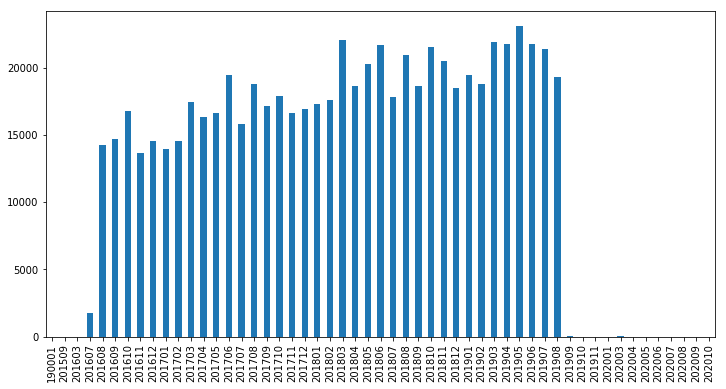

In [19]:
#convert to Month and Year an count the number of shipments
df.loc[df['BookedDate'].isna(), 'BookedDate'] = pd.to_datetime('1/1/1900') #set missing values to 1/1/1900
df['BookedYM'] = df['BookedDate'].map(lambda x: x.strftime('%Y%m'))
df['BookedYM'].value_counts().sort_index().plot(kind='bar', figsize=(12,6), rot=90)

The majority of these date values have a similar time range as CreateDate

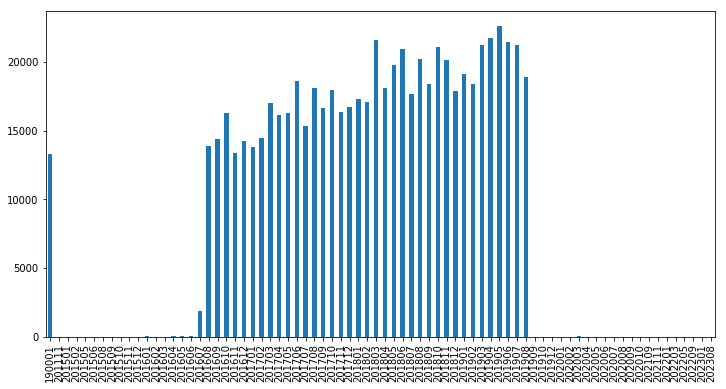

In [20]:
#convert to Month and Year an count the number of shipments
df.loc[df['PickupDate'].isna(), 'PickupDate'] = pd.to_datetime('1/1/1900') #set missing values to 1/1/1900
df['PickYM'] = df['PickupDate'].map(lambda x: x.strftime('%Y%m'))
df['PickYM'].value_counts().sort_index().plot(kind='bar', figsize=(12,6), rot=90)

There are a large number of missing PickupValues, but the time range is similar to the other date features.

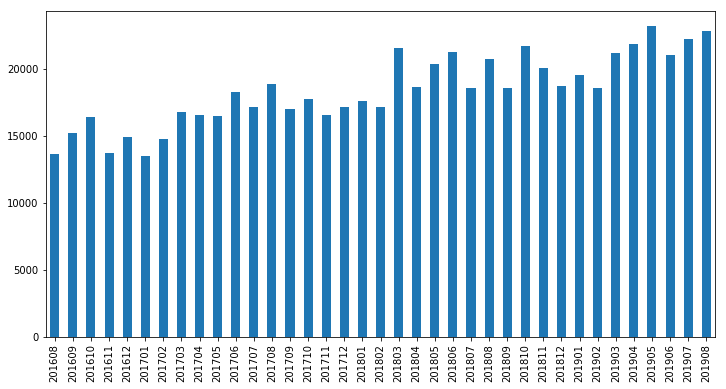

In [21]:
#convert to Month and Year an count the number of shipments
df.loc[df['DeliveryDate'].isna(), 'DeliveryDate'] = pd.to_datetime('1/1/1900') #set missing values to 1/1/1900
df['DeliveryYM'] = df['DeliveryDate'].map(lambda x: x.strftime('%Y%m'))
df['DeliveryYM'].value_counts().sort_index().plot(kind='bar', figsize=(12,6), rot=90)

In [22]:
#create date mask
l_date = pd.to_datetime('8/1/2016')
u_date = pd.to_datetime('8/1/2019')
m_dates = (df['CreatedDate'] >= l_date) & (df['CreatedDate'] <= u_date)

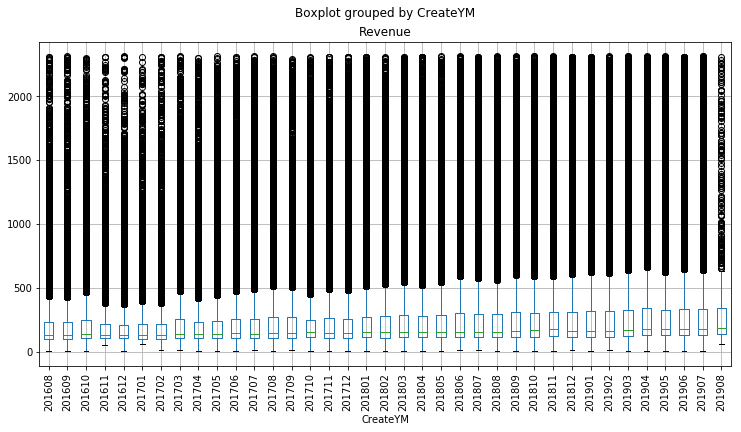

In [23]:
df.loc[m_dates].boxplot('Revenue', by='CreateYM', figsize=(12,6), rot=90)

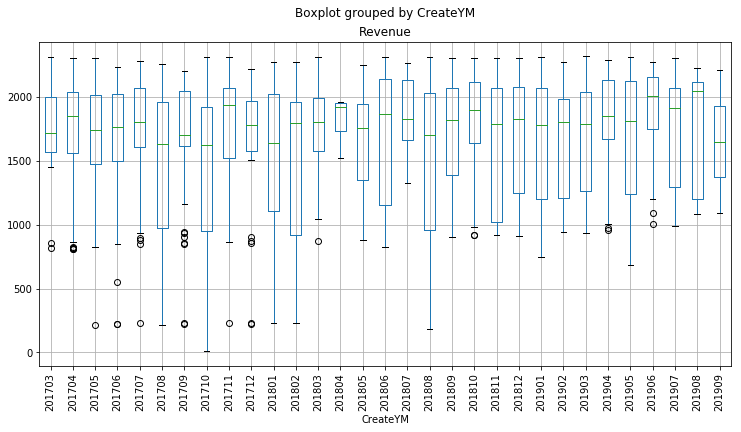

In [24]:
m_lane = (df['OriginCode']=='6224339') & (df['DestinationCode']=='6224331')
df.loc[m_lane].boxplot('Revenue', by='CreateYM', figsize=(12,6), rot=90)

Revenue does appear to change a lot by year / month.

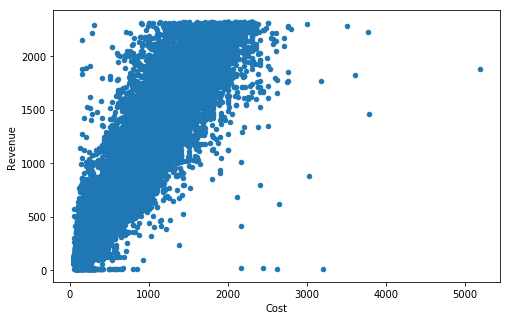

In [60]:
#Explore Cost and Revenue Relationship
df.plot(kind='scatter', y='Revenue', x='Cost', figsize=(8, 5))

There appears to be a linear relationship with Costs. This makes sense, because as a business you would want to target a margin on every shipment. However, there appears to be some shipments with greater costs than revenue. I do not know if this value is available at prediction time.

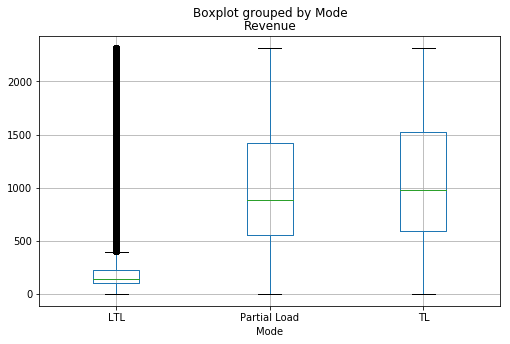

In [59]:
#Explore Mode
df.boxplot('Revenue', by='Mode', figsize=(8, 5))

There appears to be a difference in the amount of revenue by mode type. LTL modes have less revenue than the other modes. 

In [27]:
#Eplore the different lanes origin to destination
df['Lane'] = df['OriginCode'] + "-" + df['DestinationCode']
print('There are this # of unique origin /destination combinations: {}'.format( len(df['Lane'].unique())))
l = df['Lane'].value_counts().sort_values(ascending=False)
print('Here are the most common lanes:')
l.head(8)

There are this # of unique origin /destination combinations: 278453
Here are the most common lanes:


6224339-6224331    1518
6070020-6763004    1272
6517215-6223196     880
6225045-6225037     846
6226715-6224463     844
6224806-6204698     769
6226813-6226349     769
6224806-6223553     765
Name: Lane, dtype: int64

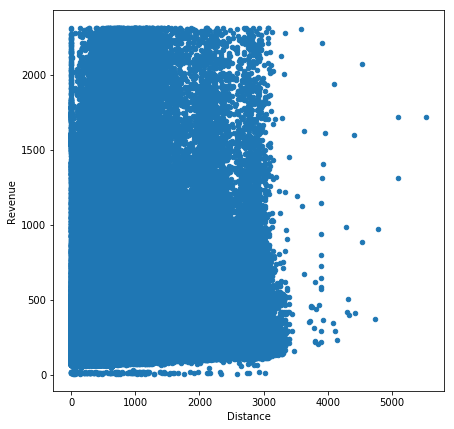

In [28]:
#Explore Distance and Revenue Relationship
df.loc[df['Distance']<10000].plot(kind='scatter', y='Revenue', x='Distance', figsize=(7,7))

There does not appear to be much relationship but what if we explore by lane.

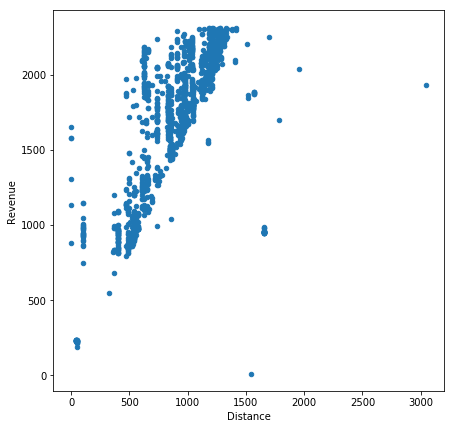

In [29]:
m_lane = (df['OriginCode']=='6224339') & (df['DestinationCode']=='6224331')
df.loc[m_lane, ['Revenue','CustomerName','Distance']].plot(kind='scatter', x='Distance', y='Revenue', figsize=(7,7))

There appears to be a relationship distance and revenue.

In [30]:
print("Num of unique list of Origins: {}".format( len(df['OriginCode'].unique()) ) )
print("Num of unique list of Destinations: {}".format( len(df['DestinationCode'].unique()) ) )
print("Num of unique list of Origins - Destinations: {}".format( len((df['OriginCode'] + 
                                                               df['OriginState'] + 
                                                               df['DestinationCode'] + 
                                                               df['DestinationState']).unique()) )) 

Num of unique list of Origins: 17493
Num of unique list of Destinations: 182892
Num of unique list of Origins - Destinations: 278389


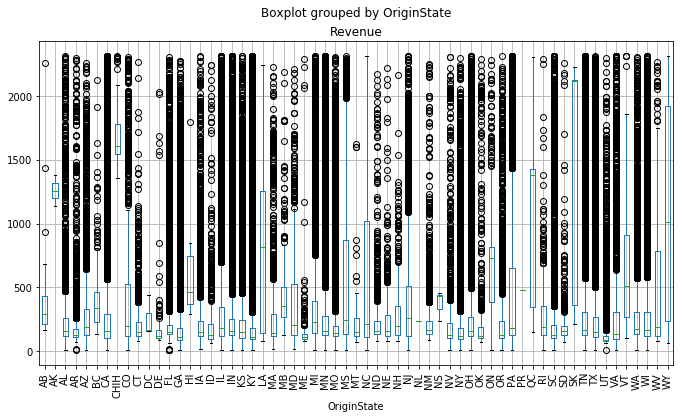

In [31]:
df.boxplot('Revenue', by='OriginState', figsize=(11,6), rot=90)

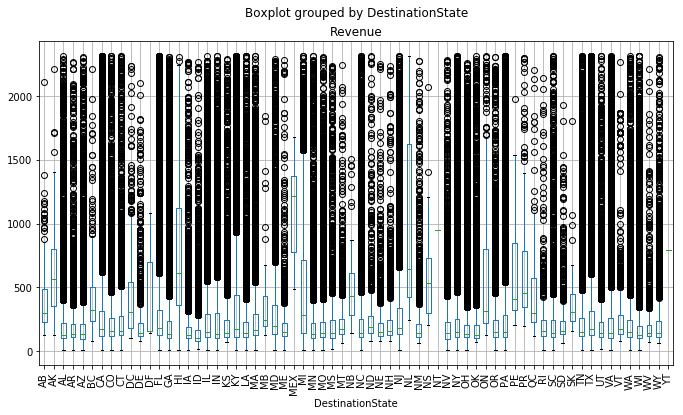

In [32]:
df.boxplot('Revenue', by='DestinationState', figsize=(11,6), rot=90)

There appears to be differences in Revenue by Origin and Destination State. For example AK has a higher than average revenue. These would be good features to incoperate. 

After exploring the data I will remove the rows with dates outside of the expected range.

In [33]:
l_date = pd.to_datetime('8/1/2016')
u_date = pd.to_datetime('8/1/2019')
f_dates = (df['CreatedDate'] >= l_date) & (df['CreatedDate'] <= u_date)
df = df.loc[f_dates]

In [34]:
#Check for missing values
pd.DataFrame([(c, sum(df[c].isna())) for c in df.columns], 
             columns=['column','missing values'])

,column,missing values
0,CustomerName,0
1,ParentName,656123
2,LoadId,0
3,SalesMedium,10214
4,CreatedDate,0
5,BookedDate,0
6,PickupDate,0
7,DeliveryDate,0
8,Revenue,0
9,Cost,11030


In [35]:
#drop Rev-z
df = df.drop('Rev-z', axis=1)

In [36]:
df = df.sort_values(['CreatedDate']).reset_index().drop('index', axis=1)

In [37]:
cleaned_df = df.copy()
cleaned_df.to_pickle('cleaned_df.pkl')

### Modeling & Feature Engineering
<a id='model'></a>

In [92]:
cleaned_df = pd.read_pickle('cleaned_df.pkl')

Although this problem is about forecasting future revenue I am treating each shipment as an indpendent of any previous shipments and therefore will not model this as a timeseries problem. 

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

In [94]:
from sklearn.model_selection import train_test_split
X = cleaned_df
seed = 12

X = pd.concat([cleaned_df.drop(['Mode','SalesMedium',
                        'ParentName','LoadId','Lane',
                        'CreateYM','DeliveryYM','BookedYM','PickYM',
                        'CreatedDate','BookedDate','PickupDate','DeliveryDate',
                        'OriginCode','DestinationCode',
                        'Cost'], axis=1), 
               pd.get_dummies(cleaned_df['Mode'], prefix='Mode', drop_first=True),
               pd.get_dummies(cleaned_df['SalesMedium'], prefix='SM'),
               pd.Series(cleaned_df['CreatedDate'].map(lambda x: x.strftime('%m')), name='CreateM')]
              , axis=1).dropna()
y = X['Revenue']


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.40, 
                                                    random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                      test_size=0.20, 
                                                      random_state=seed)

#Find the median values of categorical variables from training set
cust_median = X_train.loc[:,['CustomerName','Revenue']].groupby('CustomerName', as_index=False).median()
cust_median = cust_median.rename({'Revenue':'CustMedianRev'}, axis=1)
origin_st_median = X_train.loc[:,['OriginState','Revenue']].groupby('OriginState', as_index=False).median()
origin_st_median = origin_st_median.rename({'Revenue':'OSMedianRev'}, axis=1)
dest_st_median = X_train.loc[:,['DestinationState','Revenue']].groupby('DestinationState', as_index=False).median()
dest_st_median = dest_st_median.rename({'Revenue':'DSMedianRev'}, axis=1)

X_train = X_train.merge(cust_median, how='left', on='CustomerName').drop('CustomerName', axis=1)
X_valid = X_valid.merge(cust_median, how='left', on='CustomerName').drop('CustomerName', axis=1)
X_test = X_test.merge(cust_median, how='left', on='CustomerName').drop('CustomerName', axis=1)
X_valid.loc[X_valid['CustMedianRev'].isna(), 'CustMedianRev'] = y_train.median()
X_test.loc[X_test['CustMedianRev'].isna(), 'CustMedianRev'] = y_train.median()
X_train = X_train.merge(origin_st_median, how='left', on='OriginState').drop('OriginState', axis=1)
X_valid = X_valid.merge(origin_st_median, how='left', on='OriginState').drop('OriginState', axis=1)
X_test = X_test.merge(origin_st_median, how='left', on='OriginState').drop('OriginState', axis=1)
X_valid.loc[X_valid['OSMedianRev'].isna(), 'OSMedianRev'] = y_train.median()
X_test.loc[X_test['OSMedianRev'].isna(), 'OSMedianRev'] = y_train.median()
X_train = X_train.merge(dest_st_median, how='left', on='DestinationState').drop('DestinationState', axis=1)
X_valid = X_valid.merge(dest_st_median, how='left', on='DestinationState').drop('DestinationState', axis=1)
X_test = X_test.merge(dest_st_median, how='left', on='DestinationState').drop('DestinationState', axis=1)
X_valid.loc[X_valid['DSMedianRev'].isna(), 'DSMedianRev'] = y_train.median()
X_test.loc[X_test['DSMedianRev'].isna(), 'DSMedianRev'] = y_train.median()

X_train = X_train.drop('Revenue',axis=1)
X_valid = X_valid.drop('Revenue',axis=1)
X_test = X_test.drop('Revenue',axis=1)

In [95]:
X_train.head()

,Distance,Mode_Partial Load,Mode_TL,SM_Contract,SM_Salesfloor,CreateM,CustMedianRev,OSMedianRev,DSMedianRev
0,138.0,0,0,0,1,01,102.0,159.0,172.0
1,776.0,0,0,0,1,09,326.0,168.0,128.0
2,207.0,0,0,0,1,05,102.0,159.0,172.0
3,1527.0,0,0,0,1,05,232.0,154.0,105.0
4,330.0,0,0,1,0,10,102.0,159.0,133.0


In [96]:
m = RandomForestRegressor(n_estimators=20, random_state=seed, n_jobs=-1)

In [97]:
m.fit(X_train, y_train)
y_hat = m.predict(X_valid)
print('The R2: {0:.4f}, MSE: {1:.2f}'.format(r2_score(y_valid, y_hat), 
                                             mean_squared_error(y_valid, y_hat)) )

The R2: 0.7797, MSE: 26730.93


In [98]:
def find_feature_importance(model, x, y, eval_metric, shuffle_num=10):
    '''
    This function returns a DataFrame with a list of the input x feature names 
    and their estimated importance to the model
    '''
    
    orig = x.copy()
    base = eval_metric(y, model.predict(x))
    output = []
    for f in x.columns:
        x_shuffled = orig.copy()
        for i in range(shuffle_num):
            col = orig.loc[:,f].sample(frac=1.0, random_state=(seed+i)).tolist()
            x_shuffled.loc[:,f] = pd.Series(col,index=x_shuffled.index)
            #the abs() value of diff is used so if eval_metric is a lost 
            #function or scorer function the diff is always a positive value
            d = np.abs(eval_metric(y, model.predict(x_shuffled)) - base)
            output.append( (f, d) )
    return (pd.DataFrame(output, columns=['feature','diff']))


In [99]:
fi = find_feature_importance(m, X_valid, y_valid, mean_squared_error, 2)
fi.groupby('feature').median().sort_values('diff', ascending=False)

,diff
feature,
Mode_TL,151063.536285
Distance,51070.160391
CustMedianRev,40480.484369
Mode_Partial Load,29741.078743
OSMedianRev,16287.361798
DSMedianRev,5609.706578
CreateM,2044.838663
SM_Contract,387.071773
SM_Salesfloor,357.252864


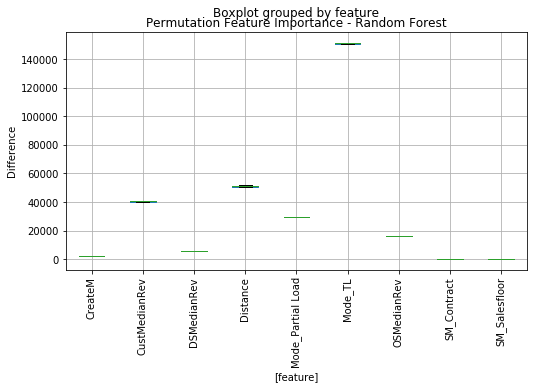

In [100]:
ax = fi.boxplot(by='feature', rot=90, figsize=(8,4.4))
ax.set_ylabel('Difference')
ax.set_title('Permutation Feature Importance - Random Forest')
plt.show()

Based on the feature importance Mode_TL and Distance are the most important. Let's explore some additional feature interactions.

In [101]:
X_train['Dist*CustMedianRev'] = X_train['Distance'] * X_train['CustMedianRev']
X_train['Dist-CustMedianRev'] = X_train['Distance'] - X_train['CustMedianRev']
X_valid['Dist*CustMedianRev'] = X_valid['Distance'] * X_valid['CustMedianRev']
X_valid['Dist-CustMedianRev'] = X_valid['Distance'] - X_valid['CustMedianRev']
X_test['Dist*CustMedianRev'] = X_test['Distance'] * X_test['CustMedianRev']
X_test['Dist-CustMedianRev'] = X_test['Distance'] - X_test['CustMedianRev']

X_train['Dist*OSMedianRev'] = X_train['Distance'] * X_train['OSMedianRev']
X_train['Dist-OSMedianRev'] = X_train['Distance'] - X_train['OSMedianRev']
X_valid['Dist*OSMedianRev'] = X_valid['Distance'] * X_valid['OSMedianRev']
X_valid['Dist-OSMedianRev'] = X_valid['Distance'] - X_valid['OSMedianRev']
X_test['Dist*OSMedianRev'] = X_test['Distance'] * X_test['OSMedianRev']
X_test['Dist-OSMedianRev'] = X_test['Distance'] - X_test['OSMedianRev']

X_train.head()

,Distance,Mode_Partial Load,Mode_TL,SM_Contract,SM_Salesfloor,CreateM,CustMedianRev,OSMedianRev,DSMedianRev,Dist*CustMedianRev,Dist-CustMedianRev,Dist*OSMedianRev,Dist-OSMedianRev
0,138.0,0,0,0,1,01,102.0,159.0,172.0,14076.0,36.0,21942.0,-21.0
1,776.0,0,0,0,1,09,326.0,168.0,128.0,252976.0,450.0,130368.0,608.0
2,207.0,0,0,0,1,05,102.0,159.0,172.0,21114.0,105.0,32913.0,48.0
3,1527.0,0,0,0,1,05,232.0,154.0,105.0,354264.0,1295.0,235158.0,1373.0
4,330.0,0,0,1,0,10,102.0,159.0,133.0,33660.0,228.0,52470.0,171.0


In [102]:
m.fit(X_train, y_train)
y_hat = m.predict(X_valid)
print('The R2: {0:.4f}, MSE: {1:.2f}'.format(r2_score(y_valid, y_hat), 
                                             mean_squared_error(y_valid, y_hat)) )

The R2: 0.7802, MSE: 26678.87


In [103]:
fi = find_feature_importance(m, X_valid, y_valid, mean_squared_error, 2)
fi.groupby('feature').median().sort_values('diff', ascending=False)

,diff
feature,
Mode_TL,147893.141468
Dist*CustMedianRev,38414.392621
CustMedianRev,33522.994599
Mode_Partial Load,29535.766473
Dist*OSMedianRev,19192.867485
OSMedianRev,13643.865911
Distance,12422.522607
Dist-OSMedianRev,8556.389280
Dist-CustMedianRev,4816.061467


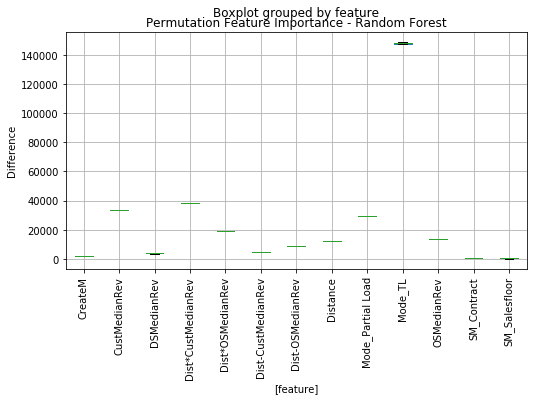

In [104]:
ax = fi.boxplot(by='feature', rot=90, figsize=(8,4.4))
ax.set_ylabel('Difference')
ax.set_title('Permutation Feature Importance - Random Forest')
plt.show()

Some Features show little to no importance. Can we filter to the most important features.

In [105]:
dl = ['SM_Salesfloor','SM_Contract','CreateM','Dist*OSMedianRev']
X_train = X_train.drop(dl, axis=1)
X_valid = X_valid.drop(dl, axis=1)
X_test = X_test.drop(dl, axis=1)

m.fit(X_train, y_train)
y_hat = m.predict(X_valid)
print('The R2: {0:.4f}, MSE: {1:.2f}'.format(r2_score(y_valid, y_hat), 
                                             mean_squared_error(y_valid, y_hat)) )

fi = find_feature_importance(m, X_valid, y_valid, mean_squared_error, 2)
fi.groupby('feature').median().sort_values('diff', ascending=False)

The R2: 0.7961, MSE: 24741.42


,diff
feature,
Mode_TL,152727.133457
CustMedianRev,34931.928810
Mode_Partial Load,29809.075327
Dist*CustMedianRev,27710.119789
Distance,17243.185507
OSMedianRev,15492.161077
Dist-OSMedianRev,13847.466562
Dist-CustMedianRev,6193.707802
DSMedianRev,5940.247192


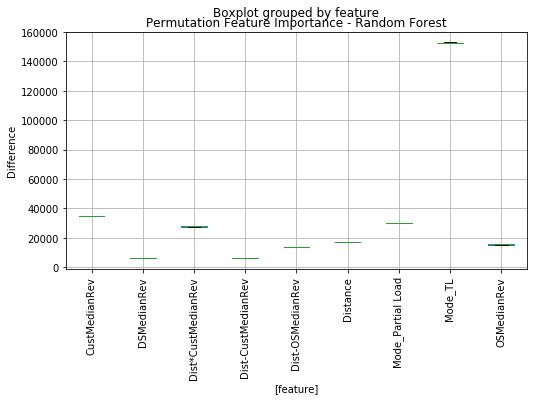

In [106]:
ax = fi.boxplot(by='feature', rot=90, figsize=(8,4.4))
ax.set_ylabel('Difference')
ax.set_title('Permutation Feature Importance - Random Forest')
plt.show()

It looks like we can remove these features without much impact to performance.

### Final Model
<a id='final'></a>
Combine all training and validation data together and train final model

In [107]:
X_train = pd.concat([X_train, X_valid], axis=0)
y_train = pd.concat([y_train, y_valid], axis=0)

In [108]:
m.fit(X_train, y_train)
y_hat = m.predict(X_test)
print('The R2: {0:.4f}, MSE: {1:.2f}'.format(r2_score(y_test, y_hat), 
                                             mean_squared_error(y_test, y_hat)) )

The R2: 0.8060, MSE: 24226.15


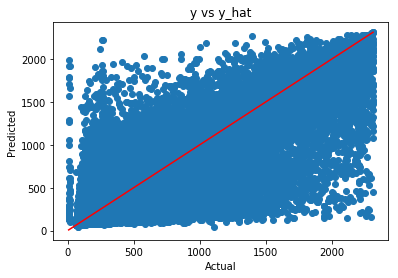

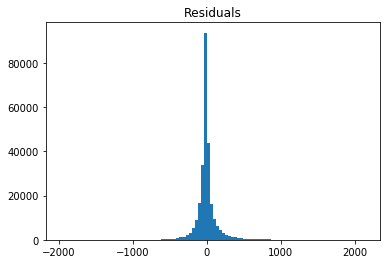

In [109]:
plt.title('y vs y_hat')
x45_line = np.linspace(min(y_test), max(y_test))
plt.scatter(y_test, y_hat)
plt.plot(x45_line, x45_line, "r-")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

resid = y_test - y_hat 
plt.title('Residuals')
plt.hist(resid, bins=100)
plt.show()

In [110]:
resid_df = pd.DataFrame({'resid':resid})
resid_df.describe()

,resid
count,264108.000000
mean,-0.815279
std,155.645694
min,-1974.927587
25%,-48.096345
50%,-8.838426
75%,20.793914
max,2143.835238


In [111]:
#Save Final model
from sklearn.externals import joblib
joblib.dump(m, 'finalModel.joblib') 

['finalModel.joblib']